In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
event_log = pd.read_csv(
    r"C:\Users\Ryzen\Desktop\Business Analytics Project Portfolio\Order-to-Delivery process\Project Portfolio\event_log_order_fulfilment_simple.csv"
)
event_log["event_time"] = pd.to_datetime(event_log["event_time"])

event_log["next_activity"] = event_log.groupby("case_id")["activity"].shift(-1)

flow = (
    event_log.dropna(subset=["next_activity"])
    .groupby(["activity", "next_activity"])
    .size()
    .reset_index(name="frequency")
    .sort_values("frequency", ascending=False)
)

flow

,activity,next_activity,frequency
8,Order Placed,Order Approved,98088
6,Order Approved,Handed to Carrier,96262
2,Handed to Carrier,Delivered to Customer,95163
5,Order Approved,Delivered to Customer,1313
7,Order Placed,Handed to Carrier,1207
3,Handed to Carrier,Order Approved,1132
4,Handed to Carrier,Order Placed,166
1,Delivered to Customer,Order Approved,61
0,Delivered to Customer,Handed to Carrier,23


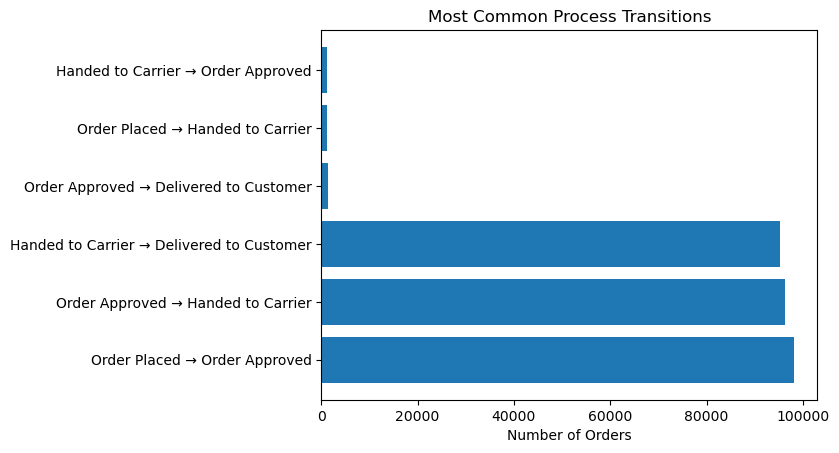

In [9]:
top_flows = flow.head(6)

plt.barh(
    top_flows["activity"] + " → " + top_flows["next_activity"],
    top_flows["frequency"]
)
plt.xlabel("Number of Orders")
plt.title("Most Common Process Transitions")
plt.show()

## Bottleneck & SLA Analysis – Order-to-Delivery Process

In [11]:
DATA_DIR = r"C:\Users\Ryzen\Desktop\Business Analytics Project Portfolio\Order-to-Delivery process\Project Portfolio"

event_log = pd.read_csv(DATA_DIR + r"\event_log_order_fulfilment_simple.csv")
kpi = pd.read_csv(DATA_DIR + r"\kpi_simple.csv")
orders = pd.read_csv(DATA_DIR + r"\orders_enriched_simple.csv")

event_log["event_time"] = pd.to_datetime(event_log["event_time"])

## Preparing data for time analysis

In [12]:
wide = (
    event_log
    .pivot_table(
        index="case_id",
        columns="activity",
        values="event_time",
        aggfunc="min"
    )
    .reset_index()
)

wide.head()


activity,case_id,Delivered to Customer,Handed to Carrier,Order Approved,Order Placed
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,2017-09-19 18:34:16,2017-09-13 09:45:35,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,2017-05-04 14:35:00,2017-04-26 11:05:13,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,2018-01-16 12:36:48,2018-01-14 14:48:30,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,2018-08-10 13:28:00,2018-08-08 10:10:18,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,2017-02-16 09:46:09,2017-02-04 14:10:13,2017-02-04 13:57:51


## Calculating time between process steps

In [13]:
wide["Placed_to_Approved_hours"] = (
    wide["Order Approved"] - wide["Order Placed"]
).dt.total_seconds() / 3600

wide["Approved_to_Carrier_hours"] = (
    wide["Handed to Carrier"] - wide["Order Approved"]
).dt.total_seconds() / 3600

wide["Carrier_to_Delivery_hours"] = (
    wide["Delivered to Customer"] - wide["Handed to Carrier"]
).dt.total_seconds() / 3600

wide["End_to_End_days"] = (
    wide["Delivered to Customer"] - wide["Order Placed"]
).dt.total_seconds() / (3600 * 24)

wide.head()

activity,case_id,Delivered to Customer,Handed to Carrier,Order Approved,Order Placed,Placed_to_Approved_hours,Approved_to_Carrier_hours,Carrier_to_Delivery_hours,End_to_End_days
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,2017-09-19 18:34:16,2017-09-13 09:45:35,2017-09-13 08:59:02,0.775833,152.811389,29.158889,7.614421
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,2017-05-04 14:35:00,2017-04-26 11:05:13,2017-04-26 10:53:06,0.201944,195.496389,193.490000,16.216181
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,2018-01-16 12:36:48,2018-01-14 14:48:30,2018-01-14 14:33:31,0.249722,45.805000,144.707778,7.948437
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,2018-08-10 13:28:00,2018-08-08 10:10:18,2018-08-08 10:00:35,0.161944,51.295000,96.077500,6.147269
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,2017-02-16 09:46:09,2017-02-04 14:10:13,2017-02-04 13:57:51,0.206111,283.598889,318.939444,25.114352


## Identifying the bottleneck

In [14]:
wide[[
    "Placed_to_Approved_hours",
    "Approved_to_Carrier_hours",
    "Carrier_to_Delivery_hours",
    "End_to_End_days"
]].describe()

activity,Placed_to_Approved_hours,Approved_to_Carrier_hours,Carrier_to_Delivery_hours,End_to_End_days
count,99281.000000,97644.000000,96475.000000,96476.000000
mean,10.419094,67.320916,223.933126,12.558702
std,26.038004,85.186249,210.242923,9.546530
min,0.000000,-4109.256111,-386.308056,0.533414
25%,0.215000,21.012222,98.398750,6.766403
50%,0.343333,43.641528,170.394444,10.217755
75%,14.580833,85.931250,288.698750,15.720327
max,4509.180556,3018.301667,4924.583333,209.628611


## SLA Breach Analysis

## Overall SLA breach rate

In [17]:
print("SLA breach rate:", kpi["sla_breached"].mean())


SLA breach rate: 0.07870998883760219


In [18]:
## Comparing delayed vs non-delayed orders
kpi.groupby("sla_breached")["end_to_end_days"].describe()

,count,mean,std,min,25%,50%,75%,max
sla_breached,,,,,,,,
False,88649.0,10.419745,6.199189,0.0,6.0,9.0,14.0,70.0
True,7827.0,31.057749,17.262025,2.0,22.0,29.0,37.0,209.0


In [20]:
## Orders that breach the SLA have significantly longer end-to-end fulfilment times. This confirms that delivery delays are not isolated events but part of a broader process inefficiency.

In [19]:
## Why are orders delayed? (business segmentation)
analysis = kpi.merge(
    orders[[
        "order_id",
        "num_items",
        "basket_value",
        "freight_value",
        "customer_state"
    ]],
    left_on="order_id",
    right_on="order_id",
    how="left"
)

analysis.groupby("sla_breached")[[
    "num_items",
    "basket_value",
    "freight_value"
]].mean()

,num_items,basket_value,freight_value
sla_breached,,,
False,1.144167,136.865148,22.668578
True,1.113453,148.070845,24.622275


In [21]:
## Delayed orders tend to have:

## - higher freight costs,

## - slightly larger order sizes.

#This suggests that order complexity and logistics cost contribute to delivery delays.